# TSAI Assignment 9

In [1]:
from utils import torch,nn,F,optim,datasets,transforms
import utils

Create Train and test Transforms - use utils module

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
# I have tried using albumetation, but couldn't get around data load errors. Hence commented

#import albumentations as A

#class ImageDataset():
#    def __init__(self, images_filepaths, transform=None):
#        self.images_filepaths = images_filepaths
#        self.transform = transform
#
#    def __len__(self):
#        return len(self.images_filepaths)

#    def __getitem__(self, idx):
#        image_filepath = self.images_filepaths[idx]
#        image = cv2.imread(image_filepath)
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#        if self.transform is not None:
#            image = self.transform(image=image)["image"]
#        return image

#train_transforms = A.Compose([
#    A.RandomCrop(width=25, height=25),  
#    A.HorizontalFlip(p=0.5),
#    A.augmentations.geometric.transforms.ShiftScaleRotate(),
#    #A.RandomBrightnessContrast(p=0.2),
#    A.augmentations.transforms.Normalize (mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),  
#    A.augmentations.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None)
#])

#train = datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=train_transforms)
#train = ImageDataset(images_filepaths='./data', transform=train_transforms)


Get the CIFAR 10 data - train dataset and test dataset

In [4]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Get the train_loader and test_loader -  batches of data used in model training/testing

In [5]:
SEED = 1



# For reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Plot some train data to make sure the loading is correct

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


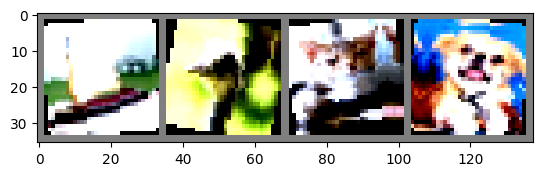

ship  bird  cat   dog  


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## MODEL - 1

In [7]:
import model
myFirstModel = model.getModel()

Print the model summary to know your model

In [8]:
utils.printModelSummary(myFirstModel,(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
             ReLU-14           [-1, 32,

Train and test your model for mutiple epochs

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(myFirstModel.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=3, verbose=True)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=98, epochs=10)


# New Line
criterion = F.nll_loss
num_epochs = 60

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  tr_Acc, tr_loss = utils.train(myFirstModel, train_loader, optimizer, criterion)
  tst_acc, tst_loss = utils.test(myFirstModel, test_loader, criterion)
  train_acc.append(tr_Acc)
  train_losses.append(tr_loss)
  test_acc.append(tst_acc)
  test_losses.append(tst_loss)
  #scheduler.step()
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 1


Train: Loss=1.5848 Batch_id=97 Accuracy=33.87: 100%|███████████████████████████████████| 98/98 [01:20<00:00,  1.22it/s]


Test set: Average loss: 1.5924, Accuracy: 4120/10000 (41.20%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 2


Train: Loss=1.4450 Batch_id=97 Accuracy=45.96: 100%|███████████████████████████████████| 98/98 [00:58<00:00,  1.69it/s]


Test set: Average loss: 1.3636, Accuracy: 5123/10000 (51.23%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 3


Train: Loss=1.1602 Batch_id=97 Accuracy=53.57: 100%|███████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Test set: Average loss: 1.1622, Accuracy: 5834/10000 (58.34%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 4


Train: Loss=1.0794 Batch_id=97 Accuracy=58.38: 100%|███████████████████████████████████| 98/98 [00:54<00:00,  1.80it/s]


Test set: Average loss: 1.0612, Accuracy: 6275/10000 (62.75%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 5


Train: Loss=1.0111 Batch_id=97 Accuracy=61.73: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.9161, Accuracy: 6716/10000 (67.16%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 6


Train: Loss=0.9018 Batch_id=97 Accuracy=64.94: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.8630, Accuracy: 6905/10000 (69.05%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 7


Train: Loss=0.7994 Batch_id=97 Accuracy=67.04: 100%|███████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Test set: Average loss: 0.8157, Accuracy: 7139/10000 (71.39%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 8


Train: Loss=0.7811 Batch_id=97 Accuracy=68.62: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.7443, Accuracy: 7353/10000 (73.53%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 9


Train: Loss=0.7330 Batch_id=97 Accuracy=70.24: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.82it/s]


Test set: Average loss: 0.7384, Accuracy: 7354/10000 (73.54%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 10


Train: Loss=0.7343 Batch_id=97 Accuracy=71.72: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.6721, Accuracy: 7628/10000 (76.28%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 11


Train: Loss=0.6800 Batch_id=97 Accuracy=72.14: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.6563, Accuracy: 7732/10000 (77.32%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 12


Train: Loss=0.7108 Batch_id=97 Accuracy=73.52: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.6435, Accuracy: 7764/10000 (77.64%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 13


Train: Loss=0.7475 Batch_id=97 Accuracy=74.26: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.6495, Accuracy: 7791/10000 (77.91%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 14


Train: Loss=0.7474 Batch_id=97 Accuracy=75.54: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.5816, Accuracy: 7979/10000 (79.79%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 15


Train: Loss=0.6663 Batch_id=97 Accuracy=76.20: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.5825, Accuracy: 7985/10000 (79.85%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 16


Train: Loss=0.5794 Batch_id=97 Accuracy=78.60: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.5061, Accuracy: 8243/10000 (82.43%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 17


Train: Loss=0.5432 Batch_id=97 Accuracy=79.93: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.4923, Accuracy: 8312/10000 (83.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 18


Train: Loss=0.5890 Batch_id=97 Accuracy=80.01: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.4903, Accuracy: 8300/10000 (83.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 19


Train: Loss=0.5660 Batch_id=97 Accuracy=80.23: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.4867, Accuracy: 8296/10000 (82.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 20


Train: Loss=0.6456 Batch_id=97 Accuracy=80.35: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4794, Accuracy: 8355/10000 (83.55%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 21


Train: Loss=0.4989 Batch_id=97 Accuracy=80.70: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4818, Accuracy: 8342/10000 (83.42%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 22


Train: Loss=0.5841 Batch_id=97 Accuracy=80.81: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4840, Accuracy: 8336/10000 (83.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 23


Train: Loss=0.5819 Batch_id=97 Accuracy=80.84: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.4759, Accuracy: 8349/10000 (83.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 24


Train: Loss=0.5776 Batch_id=97 Accuracy=81.18: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4789, Accuracy: 8338/10000 (83.38%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 25


Train: Loss=0.5645 Batch_id=97 Accuracy=81.33: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.88it/s]


Test set: Average loss: 0.4696, Accuracy: 8360/10000 (83.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 26


Train: Loss=0.5153 Batch_id=97 Accuracy=81.32: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4690, Accuracy: 8367/10000 (83.67%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 27


Train: Loss=0.5943 Batch_id=97 Accuracy=81.23: 100%|███████████████████████████████████| 98/98 [00:55<00:00,  1.78it/s]


Test set: Average loss: 0.4693, Accuracy: 8354/10000 (83.54%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 28


Train: Loss=0.5281 Batch_id=97 Accuracy=81.52: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4641, Accuracy: 8382/10000 (83.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 29


Train: Loss=0.5535 Batch_id=97 Accuracy=81.46: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4656, Accuracy: 8357/10000 (83.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 30


Train: Loss=0.4609 Batch_id=97 Accuracy=81.70: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4655, Accuracy: 8368/10000 (83.68%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 31


Train: Loss=0.4822 Batch_id=97 Accuracy=81.98: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4579, Accuracy: 8384/10000 (83.84%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 32


Train: Loss=0.5569 Batch_id=97 Accuracy=81.97: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4555, Accuracy: 8406/10000 (84.06%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 33


Train: Loss=0.4644 Batch_id=97 Accuracy=82.40: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.4556, Accuracy: 8412/10000 (84.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 34


Train: Loss=0.5327 Batch_id=97 Accuracy=82.01: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4565, Accuracy: 8403/10000 (84.03%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 35


Train: Loss=0.5008 Batch_id=97 Accuracy=82.42: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4529, Accuracy: 8421/10000 (84.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 36


Train: Loss=0.4964 Batch_id=97 Accuracy=82.43: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.4540, Accuracy: 8405/10000 (84.05%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 37


Train: Loss=0.4813 Batch_id=97 Accuracy=82.27: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 0.4537, Accuracy: 8433/10000 (84.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 38


Train: Loss=0.5250 Batch_id=97 Accuracy=82.28: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.4523, Accuracy: 8424/10000 (84.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 39


Train: Loss=0.6041 Batch_id=97 Accuracy=82.22: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4531, Accuracy: 8417/10000 (84.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 40


Train: Loss=0.5145 Batch_id=97 Accuracy=82.15: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4548, Accuracy: 8417/10000 (84.17%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 41


Train: Loss=0.5395 Batch_id=97 Accuracy=82.46: 100%|███████████████████████████████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 0.4527, Accuracy: 8420/10000 (84.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 42


Train: Loss=0.4607 Batch_id=97 Accuracy=82.20: 100%|███████████████████████████████████| 98/98 [00:53<00:00,  1.85it/s]


Test set: Average loss: 0.4514, Accuracy: 8420/10000 (84.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 43


Train: Loss=0.5866 Batch_id=97 Accuracy=82.22: 100%|███████████████████████████████████| 98/98 [00:54<00:00,  1.79it/s]


Test set: Average loss: 0.4517, Accuracy: 8432/10000 (84.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 44


Train: Loss=0.5351 Batch_id=97 Accuracy=82.20: 100%|███████████████████████████████████| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.4505, Accuracy: 8436/10000 (84.36%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 45


Train: Loss=0.5997 Batch_id=97 Accuracy=82.46: 100%|███████████████████████████████████| 98/98 [00:58<00:00,  1.67it/s]


Test set: Average loss: 0.4521, Accuracy: 8429/10000 (84.29%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 46


Train: Loss=0.5167 Batch_id=97 Accuracy=82.41: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.4540, Accuracy: 8417/10000 (84.17%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 47


Train: Loss=0.5050 Batch_id=97 Accuracy=82.36: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Test set: Average loss: 0.4514, Accuracy: 8422/10000 (84.22%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 48


Train: Loss=0.5650 Batch_id=97 Accuracy=82.16: 100%|███████████████████████████████████| 98/98 [00:57<00:00,  1.71it/s]


Test set: Average loss: 0.4514, Accuracy: 8432/10000 (84.32%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 49


Train: Loss=0.5793 Batch_id=97 Accuracy=82.48: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.74it/s]


Test set: Average loss: 0.4500, Accuracy: 8438/10000 (84.38%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 50


Train: Loss=0.4913 Batch_id=97 Accuracy=82.54: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.4509, Accuracy: 8424/10000 (84.24%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 51


Train: Loss=0.4933 Batch_id=97 Accuracy=82.53: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Test set: Average loss: 0.4509, Accuracy: 8424/10000 (84.24%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 52


Train: Loss=0.5085 Batch_id=97 Accuracy=82.37: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Test set: Average loss: 0.4515, Accuracy: 8427/10000 (84.27%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 53


Train: Loss=0.5080 Batch_id=97 Accuracy=82.58: 100%|███████████████████████████████████| 98/98 [00:57<00:00,  1.69it/s]


Test set: Average loss: 0.4513, Accuracy: 8423/10000 (84.23%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 54


Train: Loss=0.4753 Batch_id=97 Accuracy=82.30: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Test set: Average loss: 0.4514, Accuracy: 8419/10000 (84.19%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 55


Train: Loss=0.5507 Batch_id=97 Accuracy=82.53: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.4508, Accuracy: 8417/10000 (84.17%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 56


Train: Loss=0.4305 Batch_id=97 Accuracy=82.51: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Test set: Average loss: 0.4502, Accuracy: 8429/10000 (84.29%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 57


Train: Loss=0.5409 Batch_id=97 Accuracy=82.48: 100%|███████████████████████████████████| 98/98 [00:57<00:00,  1.72it/s]


Test set: Average loss: 0.4504, Accuracy: 8430/10000 (84.30%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 58


Train: Loss=0.5184 Batch_id=97 Accuracy=82.41: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.72it/s]


Test set: Average loss: 0.4505, Accuracy: 8429/10000 (84.29%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 59


Train: Loss=0.5116 Batch_id=97 Accuracy=82.40: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.4495, Accuracy: 8430/10000 (84.30%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 60


Train: Loss=0.5385 Batch_id=97 Accuracy=82.51: 100%|███████████████████████████████████| 98/98 [00:56<00:00,  1.73it/s]


Test set: Average loss: 0.4510, Accuracy: 8423/10000 (84.23%)

Adjusting learning rate of group 0 to 1.0000e-05.


Plot the train and test accuracy

In [ ]:
utils.printModelTrainTestAccuracy(train_acc, train_losses, test_acc, test_losses)